In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow.keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Features = pd.read_csv("features.csv")

In [3]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [4]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [5]:
Y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [6]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162), (2376, 6), (792, 162), (792, 6))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162), (2376, 6), (792, 162), (792, 6))

In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162, 1), (2376, 6), (792, 162, 1), (792, 6))

In [9]:
x_train.shape[1]

162

Hyperparameter Tuning -- Bayesian Optimization

In this project the final model for further analysis is tuned manually and is a bit higher than the output model from bayesian optimization. But we present the results here since this method is more stable in finding a set of good enough hyperparameters.

In [10]:
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK, rand
from hyperopt.pyll import scope
from sklearn import metrics

In [11]:
CNN_param_hyperopt = {
    'uni':scope.int(hp.uniform('uni', 150,300)),
    'layers':scope.int(hp.uniform('units', 4,6)),
    'act':hp.choice('act',['relu','tanh']),
    'kernel_size':scope.int(hp.uniform('kernel_size', 6,10)),
    'strides':scope.int(hp.uniform('strides', 1,4)),
    'Dropout':hp.uniform('Dropout', 0.05,0.2)
}
#if use radiant, it will start from 0. So use scope.int instead

In [12]:
def model_param(space):
    input_dim = x_train.shape[1]
    model = Sequential()
    #model.add(Input(shape=(input_dim, )))
    for i in range(space['layers']):
        model.add(Conv1D(space['uni'], kernel_size=space['kernel_size'], strides=space['strides'], padding='same', activation=space['act'], input_shape=(x_train.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=4, strides = 4, padding = 'same'))
        if i == 2:
          model.add(Dropout(space['Dropout']))
    model.add(Flatten())
    model.add(Dense(units=32, activation=space['act']))
    model.add(Dropout(space['Dropout']))
    model.add(Dense(units=6, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)

    history = model.fit(x_train, y_train, batch_size=80, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

    pred_test = model.predict(x_test)
    y_pred_label = encoder.inverse_transform(pred_test)
    y_test_label = encoder.inverse_transform(y_test)

    df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    df['Predicted Labels'] = y_pred_label.flatten()
    df['Actual Labels'] = y_test_label.flatten()

    total_length = df.shape[0]
    accuracy_count = 0
    for i in range(total_length):
      if df.iloc[i,0] == df.iloc[i,1]:
        accuracy_count += 1
    accuracy_clf = float(accuracy_count/total_length)

    return {'loss': -accuracy_clf, 'status': STATUS_OK, 'model':model, 'model_history':history}

In [13]:
#tenserflow deleted the function predict_classes in 2.6 version
import time
start_time = time.time()
trials = Trials()
best_CNN = fmin(fn = model_param, space = CNN_param_hyperopt, algo = tpe.suggest, max_evals = 50, trials = trials)
print('time cost: ', time.time()-start_time)

Epoch 1/50                                                                                                             

30/30 [==============================] - 2s 45ms/step - loss: 1.7137 - accuracy: 0.2597 - val_loss: 1.6662 - val_accuracy: 0.2563 - lr: 0.0010

Epoch 2/50                                                                                                             

30/30 [==============================] - 1s 42ms/step - loss: 1.6373 - accuracy: 0.3274 - val_loss: 1.5796 - val_accuracy: 0.3737 - lr: 0.0010

Epoch 3/50                                                                                                             

30/30 [==============================] - 1s 42ms/step - loss: 1.5490 - accuracy: 0.3809 - val_loss: 1.5009 - val_accuracy: 0.3889 - lr: 0.0010

Epoch 4/50                                                                                                             

30/30 [==============================] - 1s 42ms/step - loss: 1.4741 - accuracy: 0.4

In [14]:
loss = trials.best_trial['result']['loss']
print('loss: ',loss, '\n')
# -loss represents the accuracy
model_tuned = trials.best_trial['result']['model']
print('tuned model: ',model_tuned)

loss:  -0.7638888888888888 

tuned model:  <keras.engine.sequential.Sequential object at 0x000001DC8D151A60>


In [15]:
y_pred = encoder.inverse_transform(model_tuned.predict(x_test)).flatten()
y_test = encoder.inverse_transform(y_test).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.80      0.84       148
        fear       0.74      0.77      0.76       135
       happy       0.74      0.72      0.73       148
     neutral       0.78      0.71      0.74        82
         sad       0.70      0.82      0.75       149
    surprise       0.76      0.74      0.75       130

    accuracy                           0.76       792
   macro avg       0.77      0.76      0.76       792
weighted avg       0.77      0.76      0.76       792



In [16]:
#model_tuned.save("model_tuned_hyperopt_v3_076.h5")

In [11]:
from keras.models import load_model
model = load_model('model_tuned_hyperopt_v3_076.h5')

In [12]:
model.predict(x_test)

array([[1.6946811e-04, 1.9009255e-03, 1.3076799e-02, 1.3726453e-02,
        9.6755636e-01, 3.5701038e-03],
       [9.6901023e-01, 2.0949751e-04, 2.6230099e-02, 2.3895393e-03,
        1.1920899e-03, 9.6851587e-04],
       [9.9931479e-01, 1.7635715e-04, 3.0926859e-04, 3.1948606e-05,
        1.2678518e-04, 4.0843253e-05],
       ...,
       [1.5560117e-03, 1.1994322e-03, 2.1514170e-01, 2.9556322e-01,
        4.8153493e-01, 5.0047147e-03],
       [6.4075379e-05, 2.0572048e-04, 3.1879754e-04, 2.4220940e-04,
        9.9904150e-01, 1.2767629e-04],
       [2.2291471e-03, 4.1695175e-01, 8.5305564e-02, 2.9247853e-01,
        9.3745343e-02, 1.0928968e-01]], dtype=float32)

In [13]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

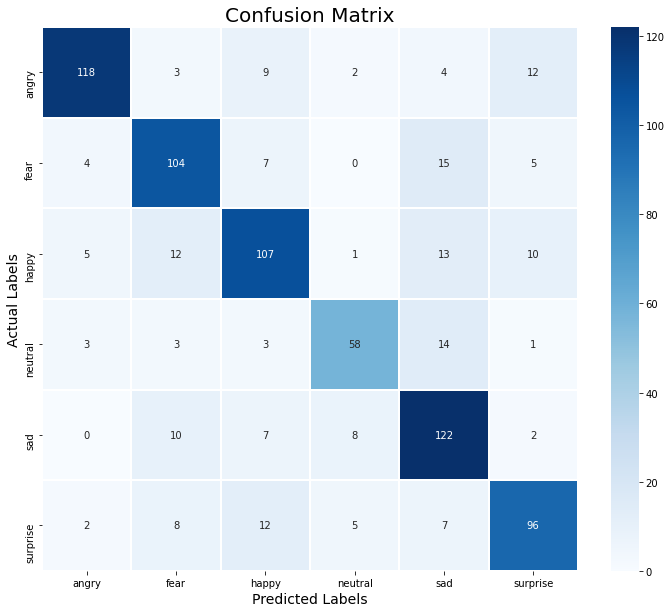

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.80      0.84       148
        fear       0.74      0.77      0.76       135
       happy       0.74      0.72      0.73       148
     neutral       0.78      0.71      0.74        82
         sad       0.70      0.82      0.75       149
    surprise       0.76      0.74      0.75       130

    accuracy                           0.76       792
   macro avg       0.77      0.76      0.76       792
weighted avg       0.77      0.76      0.76       792



In [16]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_101 (Conv1D)         (None, 162, 299)          2691      
                                                                 
 max_pooling1d_101 (MaxPooli  (None, 41, 299)          0         
 ng1D)                                                           
                                                                 
 conv1d_102 (Conv1D)         (None, 41, 299)           715507    
                                                                 
 max_pooling1d_102 (MaxPooli  (None, 11, 299)          0         
 ng1D)                                                           
                                                                 
 conv1d_103 (Conv1D)         (None, 11, 299)           715507    
                                                                 
 max_pooling1d_103 (MaxPooli  (None, 3, 299)         